In [ ]:
# pip install CoolProp
!pip install tqdm

In [2]:
import pandas as pd
from CoolProp.CoolProp import PropsSI
from CoolProp.CoolProp import AbstractState
import CoolProp
import numpy as np
import math
from tqdm import tqdm
from tql.edos import *
from tql.utils import *
from tql.modelos import *
from tql.parametros_variables import *
from tql.propiedades import *

In [4]:


# Crear una instancia de Pastparams
past_params = Pastparams()

# Definir el número de efecto
efecto = 1  # Probando el efecto 3

# Crear una instancia de EvapEffectParams
evap_params = EvapEffectParams(past_params, efecto)

# Definir los parámetros de prueba
Tsat = 363.15  # Temperatura de saturación en K (90°C)
T_w = 343.15   # Temperatura de la pared en K (70°C)
m_2_e_p = 4500  # Flujo másico de evaporación en kg/h

# Calcular h_evap y mostrar el resultado
h_evap_value = evap_params.h_evap(Tsat, T_w, m_2_e_p)
print(f"h_evap para el efecto {efecto}: {h_evap_value} W/m²·K")



h_evap para el efecto 1: 144.62676903082942 W/m²·K


In [14]:
(4 * 0.33333333)/(PropsSI('V','T',353,'Q',1,'water')*3.14*0.95)
PropsSI('Prandtl','T',333,'Q',0.8,'water')

1.0285464528662966

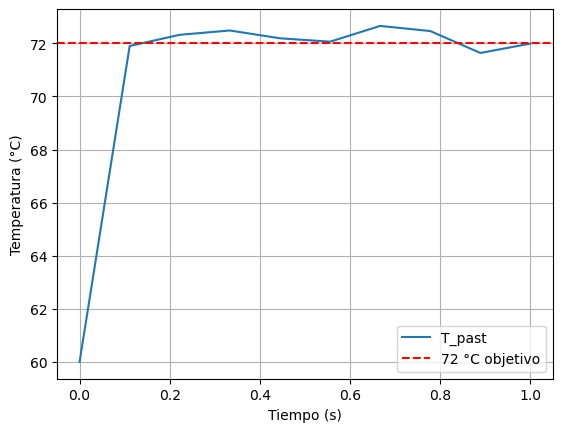

T_final = 71.99 °C


In [6]:
if __name__ == "__main__":
    # Ejemplo de uso / prueba
    # 1) Creamos el objeto de parámetros
    pparams = Pastparams()

    # 2) Simulamos
    t_span = (0, 1)    # 0 a 2000 s, por ejemplo
    T0 = 60.0             # arranca a 60°C
    sol = simulate_pasteurization(t_span, T0, pparams)
    
    # 3) Graficamos
    t_eval = np.linspace(t_span[0], t_span[1], 10)
    Tpast_sol = sol.sol(t_eval)[0]  # hay solo 1 estado
    import matplotlib.pyplot as plt
    plt.plot(t_eval, Tpast_sol, label='T_past')
    plt.axhline(72, color='r', linestyle='--', label='72 °C objetivo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Temperatura (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4) Imprimimos valor final
    print(f"T_final = {Tpast_sol[-1]:.2f} °C")

In [4]:
np.random.uniform(70,74)
    

73.31056027791084

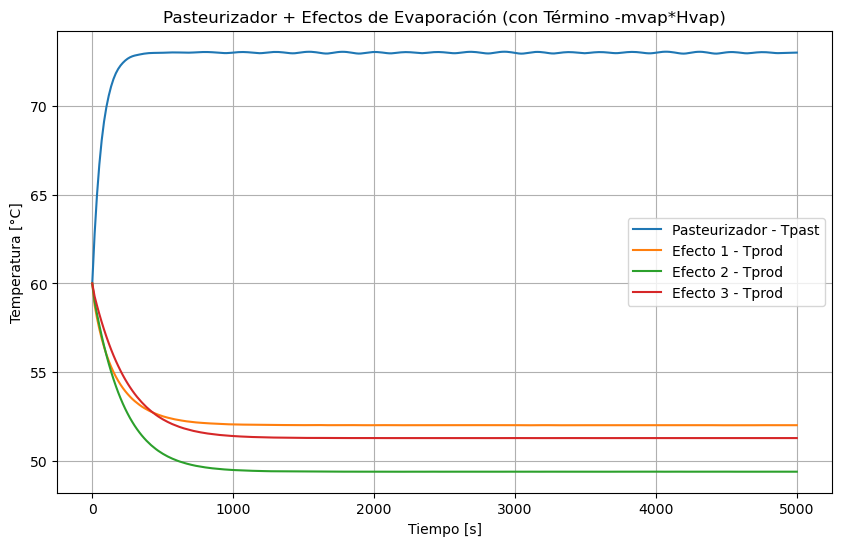

T final en el último efecto: 51.27 °C


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


##################################################
# 1) PASTEURIZADOR
##################################################
def pasteurization_ode(t, y, params):
    """
    EDO del pasteurizador:
    dTpast/dt = [ m_suero*cp_suero*(T_in - Tpast)
                  + U*A*(T_vapor - Tpast) ]
                / ( m_hold * cp_suero )
    y = [Tpast]
    """
    Tpast = y[0]

    # Parámetros
    m_suero = params["m_suero"]  # kg/s (flujo)
    cp_suero = params["cp_suero"]  # J/(kg*K)
    m_hold = params["m_hold"]  # kg en el pasteurizador
    U = params["U"]  # W/(m2*K)
    A = params["A"]  # m2
    T_in = params["T_in"]  # °C
    T_vapor = params["T_vapor"]  # °C

    # Balance de energía
    Q_suero = m_suero * cp_suero * (T_in - Tpast)
    Q_vapor = U * A * (T_vapor - Tpast)

    dTpast_dt = (Q_suero + Q_vapor) / (m_hold * cp_suero)
    return [dTpast_dt]


def simulate_pasteurization(t_span, T0, params):
    """
    Resuelve la ODE del pasteurizador en [t_span].
    - T0: temperatura inicial (°C)
    - params: diccionario con parámetros
    Retorna 'sol' con 'sol.t', 'sol.y', y 'sol.sol' (dense_output).
    """
    sol = solve_ivp(
        fun=pasteurization_ode,
        t_span=t_span,
        y0=[T0],
        args=(params,),
        dense_output=True,
    )
    return sol


##################################################
# 2) EVAPORADOR
##################################################
def evaporator_effect_ode_evap(t, y, params, T_in_func):
    """
    Modelo dinámico p/con evaporación (masa fija en el efecto).
    y = [T_wall, T_prod]

    Ecuaciones:

    (a) Pared:
       m_wall*cp_wall * dT_wall/dt
         = h_out*A*(T_steam - T_wall)
           - h_in*A*(T_wall - T_prod)

    (b) Producto:
       m_prod*cp_prod * dT_prod/dt
         = dotm_in*cp_prod*(T_in - T_prod)
           + h_in*A*(T_wall - T_prod)
           - mvap*Hvap

    donde mvap = params["mvap"] (asumida cte) o la calculas según tu modelo.
    """
    T_wall, T_prod = y

    # Extraemos parámetros
    m_wall = params["m_wall"]
    cp_wall = params["cp_wall"]
    m_prod = params["m_prod"]
    cp_prod = params["cp_prod"]
    dotm_in = params["dotm_in"]  # kg/s (alimentación)
    h_in = params["h_in"]
    h_out = params["h_out"]
    A = params["A"]
    T_steam = params["T_steam"]  # Vapor cond.
    Hvap = params["Hvap"]  # J/kg (calor latente)
    mvap = params["mvap"]  # kg/s (flujo evaporado, sup. cte)

    # T_in(t) => temperatura de entrada del producto en tiempo t
    T_in = T_in_func(t)

    # EDO (a) Pared
    dT_wall_dt = (h_out * A * (T_steam - T_wall) - h_in * A * (T_wall - T_prod)) / (
        m_wall * cp_wall
    )

    # EDO (b) Producto (con evaporación)
    dT_prod_dt = (
        dotm_in * cp_prod * (T_in - T_prod)
        + h_in * A * (T_wall - T_prod)
        - mvap * Hvap  # <-- Término de evaporación
    ) / (m_prod * cp_prod)

    return [dT_wall_dt, dT_prod_dt]


def simulate_evaporator_effect_evap(t_span, y0, params, T_in_func):
    """
    Resuelve el efecto de evaporación (con evaporación) en [t_span].
    y0 = [T_wall0, T_prod0]
    T_in_func(t) => da la T de alimentación en cada instante.

    Retorna 'sol' con dense_output.
    """
    sol = solve_ivp(
        fun=lambda t, y: evaporator_effect_ode_evap(t, y, params, T_in_func),
        t_span=t_span,
        y0=y0,
        dense_output=True,
    )
    return sol


##################################################
# 3) FUNCIÓN PRINCIPAL: PASTEURIZADOR + N EFECTOS
##################################################
def main_simulation():
    # --- PARÁMETROS DE TIEMPO ---
    t_span = (0, 5000)  # simulamos 0 a 5000 s

    # ----------------------------------------------------------------
    # 1) Simulación del Pasteurizador
    # ----------------------------------------------------------------
    pasteur_params = {
        "m_suero": 1.0,  # kg/s
        "cp_suero": 4000.0,  # J/(kg*K)
        "m_hold": 200.0,  # kg
        "U": 1500.0,  # W/(m2*K)
        "A": 5.0,  # m2
        "T_in": 60.0,  # °C (suero entra a 60°C)
        "T_vapor": 80.0,  # °C
    }
    T0_pasteur = 60.0
    sol_past = simulate_pasteurization(t_span, T0_pasteur, pasteur_params)

    # Función que devuelve T_past(t) desde la solución del pasteurizador
    def T_past_func(t):
        return sol_past.sol(t)[0]  # T_past(t) es la única variable

    # ----------------------------------------------------------------
    # 2) Definimos N efectos de evaporación
    #    (cada uno con sus parámetros, p.ej. en una lista)
    # ----------------------------------------------------------------
    N_efectos = 3

    # Creamos una lista de diccionarios, uno por cada efecto:
    efectos_params = [
        # Efecto 1
        {
            "m_wall": 500.0,  # kg
            "cp_wall": 500.0,
            "m_prod": 800.0,  # kg
            "cp_prod": 3800.0,
            "dotm_in": 1.0,  # kg/s
            "h_in": 1000.0,
            "h_out": 3000.0,
            "A": 15.0,
            "T_steam": 85.0,  # °C (vapor cond. en 1er efecto)
            "Hvap": 2.256e6,  # J/kg
            "mvap": 0.2,  # kg/s evaporado (p.ej. cte)
        },
        # Efecto 2
        {
            "m_wall": 400.0,
            "cp_wall": 500.0,
            "m_prod": 700.0,
            "cp_prod": 3800.0,
            "dotm_in": 1.0,
            "h_in": 1200.0,
            "h_out": 3500.0,
            "A": 12.0,
            "T_steam": 80.0,  # °C
            "Hvap": 2.256e6,
            "mvap": 0.15,  # kg/s evaporado
        },
        # Efecto 3
        {
            "m_wall": 300.0,
            "cp_wall": 500.0,
            "m_prod": 600.0,
            "cp_prod": 3800.0,
            "dotm_in": 1.0,
            "h_in": 1300.0,
            "h_out": 4000.0,
            "A": 10.0,
            "T_steam": 75.0,
            "Hvap": 2.256e6,
            "mvap": 0.1,
        },
    ]

    # Estados iniciales (T_wall, T_prod) para cada efecto
    Twall0 = 60.0
    Tprod0 = 60.0

    # Almacenar las soluciones en una lista
    soluciones_efectos = []

    # La salida del pasteurizador alimenta al 1er efecto:
    T_in_func_efecto = T_past_func  # arranque

    # Iteramos sobre cada efecto
    for i in range(N_efectos):
        params_ef = efectos_params[i]
        # Simulamos en [t_span] con y0
        y0_ef = [Twall0, Tprod0]
        sol_ef = simulate_evaporator_effect_evap(
            t_span=t_span, y0=y0_ef, params=params_ef, T_in_func=T_in_func_efecto
        )
        soluciones_efectos.append(sol_ef)

        # La temperatura de salida del efecto i
        # => Tprod(t) = sol_ef.sol(t)[1]
        def make_input_func(sol):
            return lambda tau: sol.sol(tau)[1]

        # La entrada al siguiente efecto = salida Tprod de este
        T_in_func_efecto = make_input_func(sol_ef)

    # ----------------------------------------------------------------
    # 3) Graficar resultados
    # ----------------------------------------------------------------
    t_eval = np.linspace(t_span[0], t_span[1], 300)

    # 3.1) Grafico la temperatura del pasteurizador
    Tpast_arr = sol_past.sol(t_eval)[0]
    plt.figure(figsize=(10, 6))
    plt.plot(t_eval, Tpast_arr, label="Pasteurizador - Tpast")

    # 3.2) Grafico la evolución de T_prod en cada efecto
    for i, sol_ef in enumerate(soluciones_efectos, start=1):
        Twall_vals = sol_ef.sol(t_eval)[0]
        Tprod_vals = sol_ef.sol(t_eval)[1]
        plt.plot(t_eval, Tprod_vals, label=f"Efecto {i} - Tprod")
        # (Opcional) también podrías graficar Twall_vals si quieres

    plt.xlabel("Tiempo [s]")
    plt.ylabel("Temperatura [°C]")
    plt.title("Pasteurizador + Efectos de Evaporación (con Término -mvap*Hvap)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Ejemplo: muestro la T final en el último efecto
    Tprod_final_ultimo = soluciones_efectos[-1].sol(t_eval[-1])[1]
    print(f"T final en el último efecto: {Tprod_final_ultimo:.2f} °C")


if __name__ == "__main__":
    main_simulation()


=== Parámetros sorteados ===
T_in       = 56.82 °C
T_vapor    = 81.43 °C
alpha      = 1.00
m_suero    = 5.69 kg/s
cp_suero    = 3909.74 j/kgK
Solución de la EDO: OK


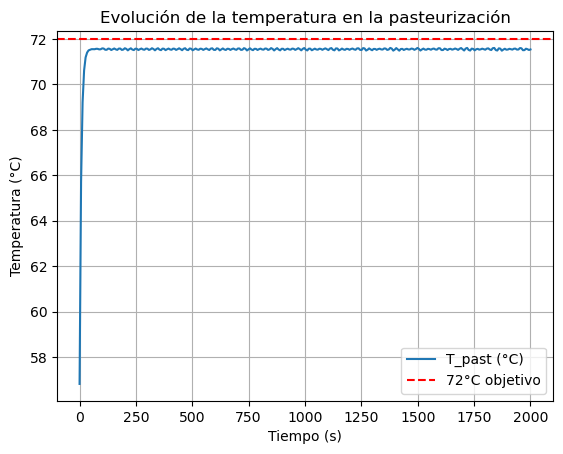

In [8]:
simulate_pasteurization()

In [6]:
efectos = 4
a = [6160, 5930, 2597, 2433]
m_evap_t = sum(a)
m_evap_t

# efecto_estacionario(efectos), KPI_evap(efectos, m_evap_t)

m_air = 30000  # kg/h DEFINIR EL INGRESO DE AIRE Y ADEMAS PONERSE EN EL CASO DONDE CONDENSA TODO EL VAPOR O NADA Y ADEMAS CALCULAR LA PRODUCCION POR HORA EN CADA MES DEL AÑO
t_in_air = 283
t_out_air = 445
P = 101325

secado(m_air, 10, 165, 175, 100)

1989.2585447955696

T = 273.15 # [K]
Tsat1 = 353.15 # [K] == 80°C
Tsat2 = 343.15

Propiedades termofísicas

Propiedades de agua líquida

P = 506000 # [Pa]
k_l = PropsSI('L', 'T', Tsat1, 'Q', 0, 'water')  # [W/m·K]
rho_l = PropsSI('D', 'T', Tsat1, 'Q', 0, 'water') # [kg/m3]
visc_l = PropsSI('V', 'T', Tsat1, 'Q', 0, 'water') # [Pa.s]
cp_l = PropsSI('C', 'T', Tsat1, 'Q', 0, 'water') # [J/kg/K]
Prl = PropsSI('Prandtl', 'T', Tsat1, 'Q', 0, 'water') # [-]
h_l = PropsSI('H', 'T', Tsat1, 'Q', 0, 'water') # [J/kg]
h_v = PropsSI('H', 'T', Tsat1, 'Q', 1, 'water') # [J/kg]
h_lv = h_v - h_l # [J/kg]

In [17]:
c = PropsSI("H", "T", 373, "Q", 1, "water")
c

2675333.1464070706

In [5]:
h_l(80, 0.115, 0)

313050.84531772963

Entalpía de cambio de fase = entalpía fase gaseosa - entalpía fase líquida


Balances de masa

Subíndice 1 indica lado de condensado, 2 indica lado de evaporación
Subíndice e indica entrada, s indica salida
Subíndica v indica vapor, c indica condensado, p indica producto, i indica interface y w indica pared.

In [1]:
# Creando prior: mitad del inicial

m_1_i_E1 = mv_evap / 2  # Fracción del vapor condensado
m_2_i_E1 = m_2_e_p / 5  # Fracción del producto evaporado

NameError: name 'mv_evap' is not defined

In [48]:
h1 = PropsSI("H", "T", 450, "P", 900000, "water")
s1 = PropsSI("S", "T", 450, "P", 900000, "water")
T1 = 450
s2 = PropsSI("S", "H", h1, "P", 500000, "water")
T2 = PropsSI("T", "H", h1, "P", 500000, "water")
m_p = 0.333333
T0 = 283
Ds = s2 - s1
E_destr = T0 * Ds

E_destr, T2, h1, s2, s1


(72888.84705389853,
 437.3278737951141,
 2776990.7295558895,
 6887.6601596039945,
 6630.102396162657)

In [53]:
E_util = (h2 - h0) - T0 * (s2 - s0)
E_util * m_p

378951.3742808084

In [14]:
hv_tsat2 = PropsSI("H", "T", 343, "Q", 1, "water")
hl_tsat2 = PropsSI("H", "T", 343, "Q", 0, "water")
hlv_tsat2 = hv_tsat2 - hl_tsat2
hv_tsat1 = PropsSI("H", "T", 353, "Q", 1, "water")
hl_tsat1 = PropsSI("H", "T", 353, "Q", 0, "water")
hlv_tsat1 = hv_tsat1 - hl_tsat1

KPI = hlv_tsat2 / hlv_tsat1

KPI


1.0108392081622102

In [ ]:
PropsSI('P','T',,'Q',1,'water')

In [50]:
E_util + E_destr

1209744.1067515833

In [60]:
hv = PropsSI("H", "T", 283, "P", 101325, "water")
s0 = PropsSI("S", "T", 283, "P", 101325, "water")
hv, s0

(41489.603094824364, 148.8539399493342)

In [62]:
h1 = PropsSI("H", "T", 450, "P", 900000, "water")
s1 = PropsSI("S", "T", 450, "P", 900000, "water")
e1 = (h1 - hv - 283 * (s1 - s0)) * 0.3333333
h1, s1, e1

(2776990.7295558895, 6630.102396162657, 300435.9077406377)

Efecto 2


In [ ]:
# fors
# steady state temps
T_w_E2 = 310.15  # 75°C
Tsat1_E2 = range(313, 353, 1)  # 40-80°C
Tsat2_E2 = range(303, 343, 1)  # 30-70°C
Tamb = 293.15  # 20°C
N = len(mv_evap)
M = len(Tsat1)
L = len(Tsat2)
# masas
m_1_e_v_E2 = mv_evap
m_1_s_v_E2 = np.zeros(N)  # init
m_1_s_c_E2 = np.zeros(N)  # init
m_e_p_E2 = np.mean(m_2_e_p)
m_2_s_p_E2 = np.zeros(N)  # init
m_2_s_v_E2 = np.zeros(N)  # init
# fluxos de calor
q_1_e_v_E2 = np.zeros((N, M))  # init
q_1_i_E2 = np.zeros((N, M))  # init
q_1_s_v_E2 = np.zeros((N, M))  # init
q_1_s_c_E2 = np.zeros((N, M))  # init
q_2_s_p_E2 = np.zeros((N, L))  # init
q_2_i_E2 = np.zeros((N, L))  # init
q_2_s_i_E2 = np.zeros((N, L))  # init
q_1_s_a_E2 = np.zeros(M)
q_1_s_w_E2 = np.zeros(M)
q_2_e_p_E2 = np.zeros(L)


for i in tqdm(range(N)):
    m_1_s_v_E2[i] = m_1_e_v_E2[i] - m_1_i_E2[i]
    m_1_s_c_E2[i] = m_1_i_E2[i]
    m_2_s_p_E2[i] = m_2_e_p[i] - m_2_i_E2[i]
    m_2_s_v_E2[i] = m_2_i_E2[i]

    # Calores entrada y salida de vapor
    for j in range(M):
        q_1_e_v_E2[i, j] = m_1_e_v_E2[i] * cp_v(Tsat1_E2[j]) * Tsat1_E2[j] / 3600
        q_1_s_a_E2[j] = (
            h_conv(Tsat1_E2[j], mv_evap[i]) * (Tsat1_E2[j] - Tamb) * a_l_evap_1
        )
        q_1_i_E2[i, j] = m_1_i_E2[i] * h_lv_corr(Tsat1_E2[j], T_w) / 3600
        q_1_s_v_E2[i, j] = (
            m_1_s_v_E2[i] * PropsSI("C", "T", Tsat1_E2[j], "Q", 1, "water") * j / 3600
        )

        # q_1_e_v[i] = q_1_s_a + q_1_i[i] + q_1_s_v[i]

        # Calores entrada y salida de condensado

        q_1_i_E2[i, j] = m_1_i_E2[i] * h_lv_corr(Tsat1_E2[j], T_w) / 3600
        q_1_s_w_E2[j] = h_cond(Tsat1_E2[j], T_w) * (Tsat1_E2[j] - T_w) * alt_1
        q_1_s_c_E2[i, j] = m_1_s_c_E2[i] * cp_l(Tsat1_E2[j]) * Tsat1_E2[j] / 3600

        # q_1_i[i] = q_1_s_w + q_1_s_c[i]

        # Calores entrada y salida producto (suero)
        for l in range(L):
            q_2_e_p_E2[l] = (
                h_evap(Tsat2_E2[l], T_w, m_e_p) * (Tsat2_E2[l] - T_w) * alt_1
            )
            q_2_s_p_E2[i, l] = m_2_s_p_E2[i] * cp_l(Tsat2_E2[l]) * Tsat2_E2[l] / 3600
            q_2_i_E2[i, l] = m_2_i_E2[i] * h_lv_corr(Tsat2_E2[l], T_w) / 3600

            # q_2_e_p = q_2_s_p[i] + q_2_i[i]

            # Calores entrada y salida de vapor producto

            q_2_s_i_E2[i, l] = m_2_i_E2[i] * cp_l(Tsat2_E2[l]) * Tsat2_E2[l] / 3600

            # q_2_i[i,l] = q_2_s_i[i,l]

        # Calor transferido a la pared (estacionario)

        # q_1_s_w[j] = q_2_e_p[l]
